### 1001 Unusual Price Movement (OPEN parameter testing)

In [1]:
import os; os.chdir('/Users/sqian/MKTSRV')
import pandas as pd; pd.set_option('mode.chained_assignment',None) 
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import re
import xlrd

from src.data_models.smartshelper import metrics, fixType, unSMART, cparty
from src.data_models.SmartsDataModel import SmartsDataModel

/Users/sqian/.pyenv/versions/3.7.0/envs/env_370/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


#### 1) Import

In [4]:
alerts_cleaned = unSMART(pd.read_excel('~/Documents/datafldr/calibration_OPENstep1.xlsx'))

-> type fixed, kept 46553 rows, 48 columns


In [ ]:
# alerts_cleaned.dtypes

#### 2) Filter on Date, Scenario

In [5]:
datefilter = (alerts_cleaned['Date'].dt.year >= 2018)
scenariofilter = alerts_cleaned['AlertCode'] == 1001
alerts0 = alerts_cleaned.loc[scenariofilter & datefilter].reset_index()

# for i in range(0,min(alerts0.shape[0],2)): print(alerts0.loc[i,'LongText'],'\n')

#### 3) Regex Parse

In [6]:
regex1001 = '\D+(Price Change.+\)).+'
alerts0['longtext_parsed'] = alerts0['LongText'].str.extract(regex1001, expand=True).rename(columns={0:'text'})

In [7]:
regex1001_p2 = 'Price Change\s(trade to trade|in the last 1 hour|in the last 10 minutes|in the last 5 minutes)\D+(-?[\d.,]+)\D+([\d,.]+)%\D+[\d.,]+\D+[\d.,]+\D+([\d.,]+)\D+([\d,.]+)%\D{1,4}'

alerts1 = alerts0[['AlertID','Datetime','AccountIDCode','ReissueCount','longtext_parsed','Date','InstrumentName']].rename(columns={'InstrumentName':'security'})
alerts1['rangesList'] = alerts1['longtext_parsed'].str.findall(regex1001_p2).tolist()

for i in range(0,min(alerts1.shape[0],2)): print(alerts1.loc[i,'rangesList'],'\n')
alerts1.head(2)

[('trade to trade', '2.10000', '90.8', '0.11550', '5'), ('in the last 5 minutes', '2.10000', '90.8', '0.11550', '5'), ('in the last 10 minutes', '2.10000', '90.8', '0.11550', '5'), ('in the last 1 hour', '2.10000', '90.8', '0.11550', '5')] 

[('in the last 10 minutes', '9.06000', '4.4', '8.16380', '4.2')] 



,AlertID,Datetime,AccountIDCode,ReissueCount,longtext_parsed,Date,security,rangesList
0,44,2018-11-01 19:46:19.823,179859.0,0,Price Change trade to trade is -$2.10000 (90.8...,2018-11-01,ZECLTC,"[(trade to trade, 2.10000, 90.8, 0.11550, 5), ..."
1,189,2018-11-04 13:26:15.433,355845.0,0,Price Change in the last 10 minutes is +$9.060...,2018-11-04,ETHUSD,"[(in the last 10 minutes, 9.06000, 4.4, 8.1638..."


#### 4) Expand Parsed Data from List to Pandas Column format

In [8]:
alerts2 = pd.concat([alerts1.drop(columns=['rangesList','longtext_parsed']), 
                     alerts1['rangesList'].apply(pd.Series).rename(columns={0:'zero',1:'one',2:'two',3:'three'})],axis=1)
alerts2.head(2)

,AlertID,Datetime,AccountIDCode,ReissueCount,Date,security,zero,one,two,three
0,44,2018-11-01 19:46:19.823,179859.0,0,2018-11-01,ZECLTC,"(trade to trade, 2.10000, 90.8, 0.11550, 5)","(in the last 5 minutes, 2.10000, 90.8, 0.11550...","(in the last 10 minutes, 2.10000, 90.8, 0.1155...","(in the last 1 hour, 2.10000, 90.8, 0.11550, 5)"
1,189,2018-11-04 13:26:15.433,355845.0,0,2018-11-04,ETHUSD,"(in the last 10 minutes, 9.06000, 4.4, 8.16380...",NaN,NaN,NaN


#### 5) Intense Reformatting of Tables

In [9]:
zeroval = alerts2.drop(columns=['one','two','three']).rename(columns={'zero':'val'})
oneval = alerts2.drop(columns=['zero','two','three']).rename(columns={'one':'val'})
twoval = alerts2.drop(columns=['one','zero','three']).rename(columns={'two':'val'})
tresval = alerts2.drop(columns=['one','two','zero']).rename(columns={'three':'val'})

alerts3 = zeroval.append(oneval).append(twoval).append(tresval).dropna().sort_values('AlertID')
alerts3.head(2)

,AlertID,Datetime,AccountIDCode,ReissueCount,Date,security,val
0,44,2018-11-01 19:46:19.823,179859.0,0,2018-11-01,ZECLTC,"(trade to trade, 2.10000, 90.8, 0.11550, 5)"
0,44,2018-11-01 19:46:19.823,179859.0,0,2018-11-01,ZECLTC,"(in the last 1 hour, 2.10000, 90.8, 0.11550, 5)"


In [10]:
alerts4 = fixType(pd.concat([alerts3.drop(columns=['val']),
                     alerts3['val'].apply(pd.Series).rename(columns={0:'range', 1:'changeACTUAL', 2:'percchangeACTUAL', 3:'changeBM', 4:'percchangeBM'})],axis=1))
alerts4['range'] = alerts4['range'].str.replace('trade to trade','t2t').str.replace('in the last','')

alerts4.to_csv('~/Desktop/Tuning1001_alerts4.csv')
alerts4.head(10)

,AlertID,Datetime,AccountIDCode,ReissueCount,Date,security,range,changeACTUAL,percchangeACTUAL,changeBM,percchangeBM
0,44.0,2018-11-01 20:46:19.823,179859.0,0.0,2018-11-01 21:18:00,ZECLTC,t2t,2.10,90.8,0.11550,5.0
0,44.0,2018-11-01 20:46:19.823,179859.0,0.0,2018-11-01 21:18:00,ZECLTC,1 hour,2.10,90.8,0.11550,5.0
0,44.0,2018-11-01 20:46:19.823,179859.0,0.0,2018-11-01 21:18:00,ZECLTC,10 minutes,2.10,90.8,0.11550,5.0
0,44.0,2018-11-01 20:46:19.823,179859.0,0.0,2018-11-01 21:18:00,ZECLTC,5 minutes,2.10,90.8,0.11550,5.0
1,189.0,2018-11-04 17:26:15.433,355845.0,0.0,2018-11-05 00:18:00,ETHUSD,10 minutes,9.06,4.4,8.16380,4.2
2,479.0,2018-11-10 07:32:31.001,677575.0,0.0,2018-11-10 05:18:00,ZECUSD,t2t,3.80,2.9,2.07534,2.5
3,485.0,2018-11-10 10:48:02.484,507080.0,0.0,2018-11-11 06:18:00,ZECUSD,t2t,3.81,2.9,2.07534,2.5
4,674.0,2018-11-13 09:30:49.909,216491.0,0.0,2018-11-13 08:18:00,ZECLTC,t2t,0.17,6.8,0.11550,5.0
4,674.0,2018-11-13 09:30:49.909,216491.0,0.0,2018-11-13 08:18:00,ZECLTC,1 hour,0.17,6.8,0.11550,5.0
4,674.0,2018-11-13 09:30:49.909,216491.0,0.0,2018-11-13 08:18:00,ZECLTC,10 minutes,0.17,6.8,0.11550,5.0


#### 6) Visualization & Analysis

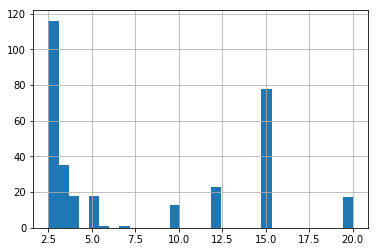

In [11]:
alerts4['percchangeBM'].hist(bins=30)

In [12]:
extreme = alerts4.loc[alerts4['percchangeACTUAL'] > 100,]
extreme

,AlertID,Datetime,AccountIDCode,ReissueCount,Date,security,range,changeACTUAL,percchangeACTUAL,changeBM,percchangeBM
30,10980.0,2018-11-25 19:47:55.385,890297.0,1.0,2018-11-25 20:18:00,ZECLTC,10 minutes,1.9370,909.4,0.11550,15.0
30,10980.0,2018-11-25 19:47:55.385,890297.0,1.0,2018-11-25 20:18:00,ZECLTC,1 hour,1.9370,909.4,0.11550,15.0
30,10980.0,2018-11-25 19:47:55.385,890297.0,1.0,2018-11-25 20:18:00,ZECLTC,t2t,1.9370,909.4,0.11550,15.0
30,10980.0,2018-11-25 19:47:55.385,890297.0,1.0,2018-11-25 20:18:00,ZECLTC,5 minutes,1.9370,909.4,0.11550,15.0
31,10989.0,2018-11-25 18:02:54.695,203777.0,0.0,2018-11-25 20:18:00,LTCETH,t2t,1.7655,683.2,0.00489,15.0
31,10989.0,2018-11-25 18:02:54.695,203777.0,0.0,2018-11-25 20:18:00,LTCETH,10 minutes,1.7655,683.2,0.00909,15.0
31,10989.0,2018-11-25 18:02:54.695,203777.0,0.0,2018-11-25 20:18:00,LTCETH,5 minutes,1.7655,683.2,0.00879,15.0
80,24843.0,2018-12-21 14:47:18.814,313223.0,0.0,2018-12-21 16:18:00,ZECBCH,t2t,0.5140,157.7,0.05601,10.0
80,24843.0,2018-12-21 14:47:18.814,313223.0,0.0,2018-12-21 16:18:00,ZECBCH,5 minutes,0.5140,157.7,0.05601,10.0
80,24843.0,2018-12-21 14:47:18.814,313223.0,0.0,2018-12-21 16:18:00,ZECBCH,10 minutes,0.5140,157.7,0.05601,10.0
